# Nonlinear Buckling Analysis of an Imperfect Euler's Column

***

In the [last notebook](06_Verification_of_SOL_106_Nonlinear_Buckling_Method.ipynb) we observed how an unreinforced box beam with a rigid tip section does not encounter a critical point under a concentrated bending load applied at the tip. SOL 106's nonlinear buckling method predicted an increasingly larger buckling load as the applied load was increased. We tried to explain this result supposing the presence of a broken bifurcation and we verified that the tangent stiffness matrix was always positive definite for the investigated load range.

In this notebook we want to test whether the same behavior can be observed for an imperfect Euler's column, that is to say an Euler's column with a slight eccentricity in the applied compression load. For this configuration we know that the equilibrium diagram consists in a broken pitchfork, where the equilibrium is always stable and no critical point is present.

* [Setup of the numerical model](#numerical-model)
* [Nonlinear buckling method verification](#verification)
* [Conclusions](#conclusions)

## Setup of the numerical model <a name="numerical-model"></a>

***

We use the same model used in our notebook on [Euler's column supercritical pitchfork bifurcation](02_Supercritical_Pitchfork_Bifurcation_Euler_Column.ipynb), that is to say a pin-ended column loaded in compression and modelled with beam elements. To break the symmetry of the problem we are going to add a small transversal load at the center of the column, as shown in the illustration below.

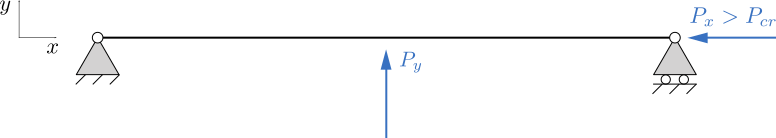

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '02_Subcase2.svg'))

Let's create a base bdf input with the function `create_base_bdf` from the `column_utils` module and define the transversal force at the center of the column.

In [2]:
from resources import column_utils
import numpy as np
from resources import pynastran_utils

# Create base bdf input
E = 207000.  # Young's modulus # [MPa]
nu = 0.3  # Poission's ratio
rho = 7.8e-4  # density [tons/mm^3]
d = 20  # diameter [mm]
l = 420  # length [mm]
no_elements = 420
bdf_input = column_utils.create_base_bdf(young_modulus=E, poisson_ratio=nu, density=rho, diameter=d, length=l, no_elements=no_elements)

# Define transverse force
compression_force_set_id = list(bdf_input.loads.keys())[0]  # find set identification number of compression force
transverse_force_set_id = compression_force_set_id + 1  # define set idenfitication number of transverse force
central_node_id = int(no_elements/2 + 1)  # find id of central node
sol_105_buckling_load = 90578.  # value found in first notebook [N]
transverse_force_magnitude = sol_105_buckling_load/100  # [N]
transverse_force_direction = [0., 1., 0.]
bdf_input.add_force(sid=transverse_force_set_id, node=central_node_id, mag=transverse_force_magnitude, xyz=transverse_force_direction)  # add FORCE card to bdf input

subcase=0 already exists...skipping


FORCE          5     211          905.78      0.      1.      0.

Finally, we set up SOL 106 with the arc-length method and define the parameters for the nonlinear buckling method and the calculation of the lowest eigenvalue of the tangent stiffness matrix.

In [3]:
pynastran_utils.set_up_arc_length_method(bdf_object=bdf_input, ninc=100, max_iter=25, conv='PUV', eps_p=1e-3, eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=1.1, desiter=5, maxinc=1000)
bdf_input.add_param('BUCKLE', [2])  # request nonlinear buckling method
eigrl_set_id = transverse_force_set_id + 1  # set identification number of EIGRL card
bdf_input.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)  # calculate only the first positive eigenvalue
bdf_input.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)  # add EIGRL card id to case control deck
bdf_input.executive_control_lines[1:1] = ['include \'' + os.path.join(os.pardir, os.pardir, 'resources', 'kllrh_lowest_eigenvalues.dmap') + '\'']  # include DMAP sequence

## Nonlinear buckling method verification <a name="verification"></a>

***

Analogously to our [previous notebook](07_Nonlinear_Buckling_Analysis_of_an_Imperfect_Euler_Column.ipynb), we want to verify whether we are able to obtain the same buckling load predicted by SOL 105 with SOL 106's nonlinear buckling method for an applied load $P_x/P_\text{SOL 105}<1$ and see how the results change when we apply larger loads. For the imperfect Euler's column we are going to define several subcases with increasing compression load and constant transversal force.

Let's define 11 compression load magnitudes equally spaced between 0 and twice the linear buckling load, discarding the load case with null magnitude and keeping the other 10.

In [4]:
compression_load_magnitudes = np.linspace(0, sol_105_buckling_load*2, 11)[1:]
np.set_printoptions(precision=0, suppress=True)
print(f'Applied compression loads [N]: {compression_load_magnitudes}')

Applied compression loads [N]: [ 18116.  36231.  54347.  72462.  90578. 108694. 126809. 144925. 163040.
 181156.]


For each compression load magnitude we add a LOAD card to the bdf input to create a load set combining the compression and the transversal loads and we create the corresponding subcase.

In [5]:
for i, scale_factor in enumerate(compression_load_magnitudes):
    load_set_id = 11 + i
    bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor, 1.], load_ids=[compression_force_set_id, transverse_force_set_id])
    pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=i+1, load_set_id=load_set_id)

Then we define the name of the analysis folder and we run our analysis.

In [6]:
# Define name of analysis directory
analysis_directory_name = '07_Verification_of_SOL_106_Nonlinear_Buckling_Method_for_the_Imperfect_Euler_Column'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

# Run analysis
input_filename = 'nonlinear_buckling_verification'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=input_filename, run_flag=False)

Nastran job nonlinear_buckling_verification.bdf completed
Wall time: 75.0 s


Let's plot the equilibrium diagram of the structure to visualize the broken bifurcation. We assess the equilibrium diagram plotting the applied compression load against the rotation $\theta$ at the pinned node on the left.

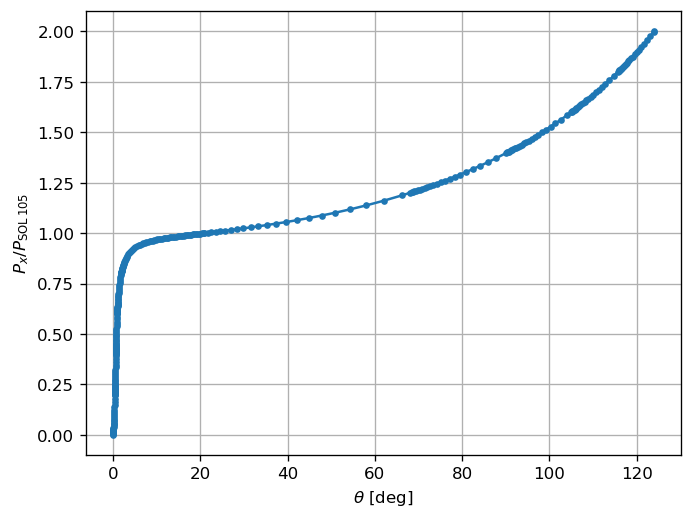

In [7]:
from pyNastran.op2.op2 import read_op2  # function to read op2 file
import matplotlib.pyplot as plt  # plotting library

# Read op2 file and read load and displacement history
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, debug=None)
steps, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=1)

# Collect loads and displacements of interest
load_component_index = 0  # select y-axis component of the load
displacement_component_index = 5  # select rotation about the z-axis
applied_load_history = np.concatenate([loads[subcase_id][:,load_component_index] for subcase_id in loads])
rotation_history = np.concatenate([displacements[subcase_id][:,displacement_component_index] for subcase_id in displacements])

# Plot applied compression load vs rotation at node 1
plt.rcParams['figure.dpi'] = 120  # set default dpi of figures
_, ax = plt.subplots()
ax.plot(np.rad2deg(rotation_history), -applied_load_history/sol_105_buckling_load, '.-')  # we add a minus sign to have a positive force in the plot
plt.xlabel('$\\theta$ [deg]')
plt.ylabel('$P_x/P_\mathrm{SOL\/105}$')
plt.grid()
plt.show()

We know that the column is always stable along the broken bifurcation path. In order to verify the positive definiteness of the tangent stiffness matrix $\mathbf{K_T}$ we read its lowest eigenvalues from the f06 file and we plot them against the applied loads.

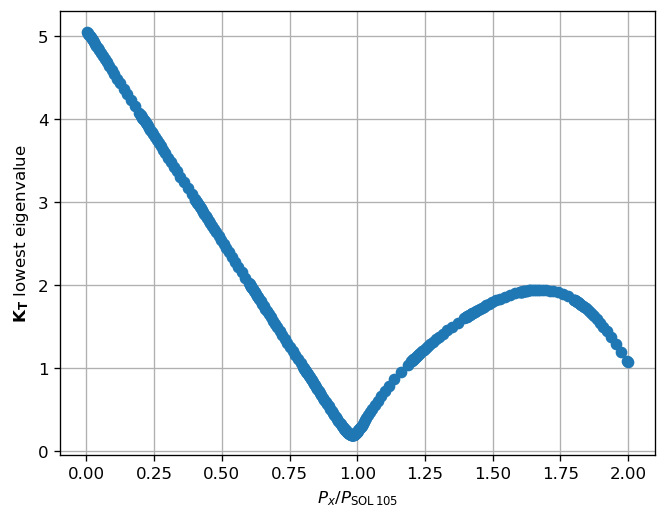

In [8]:
# Read the lowest eigenvalue of KLLRH matrices from f06 file
f06_filepath = os.path.join(analysis_directory_path, input_filename + '.f06')  # path to .f06 file
lowest_eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)

# Create new figure and plot lowest eigenvalues vs applied loads
_, ax = plt.subplots()
ax.plot(-applied_load_history/sol_105_buckling_load, lowest_eigenvalues[0, :], 'o')
plt.xlabel('$P_x/P_\mathrm{SOL\/105}$')
plt.ylabel('$\mathbf{K_T}$ lowest eigenvalue')
plt.grid()
plt.show()

We observe a linear drop of the lowest eigenvalue for $P_x/P_\text{SOL 105}<1$ until a minimum is reached, then we see an increase up to a local maximum and then another drop. The lowest eigenvalue is always positive and never crosses zero for the investigated load range. As a consequence, we can state that the structure is always stable and never encounters a critical point, as expected.

Now let's find the critical buckling loads and the critical buckling factors $\alpha$ predicted by SOL 106 reading the f06 file and let's plot them against the applied loads.

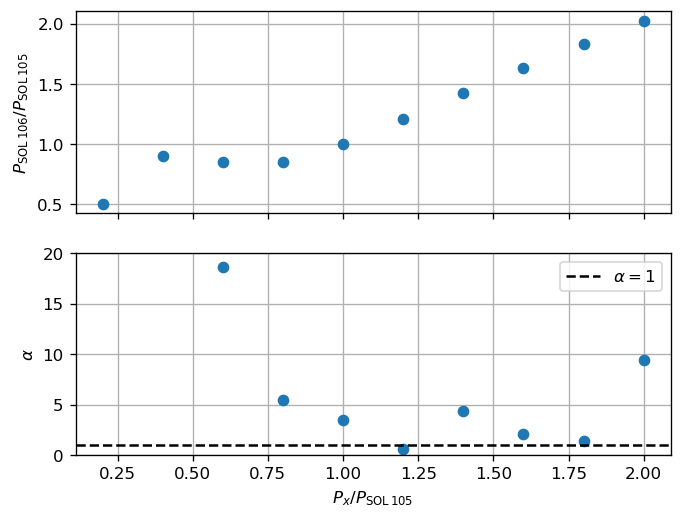

In [9]:
# Find nonlinear buckling loads and critical buckling factors
sol_106_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_filename + '.f06'), op2_object=op2_output)

# Plot nonlinear buckling loads and critical buckling factors against applied loads
_, axs = plt.subplots(nrows=2, ncols=1, sharex='all')  # figure with 2 subplots
axs[0].plot(compression_load_magnitudes/sol_105_buckling_load, sol_106_buckling_loads/sol_105_buckling_load, 'o')  # buckling loads vs applied loads
axs[1].plot(compression_load_magnitudes/sol_105_buckling_load, critical_buckling_factors, 'o')  # critical buckling factors vs applied loads
axs[1].axhline(y=1, color='k', ls='--', label='$\\alpha=1$')  # alpha=1 reference line

# Set plot appearance
axs[0].set_ylabel('$P_\mathrm{SOL\/106}/P_\mathrm{SOL\/105}$')
axs[0].grid(visible=True)
axs[1].set_ylabel('$\\alpha$')
axs[1].grid(visible=True)
axs[1].legend()
axs[1].set_xlabel('$P_x/P_\mathrm{SOL\/105}$')
axs[1].set_ylim([0, 20])
plt.show()

The results are similar to what we obtained in our [previous notebook](07_Nonlinear_Buckling_Analysis_of_an_Imperfect_Euler_Column.ipynb#verification) for the box beam. We observe a nearly constant nonlinear buckling load for $P_x/P_\text{SOL 105}<1$, slighly lower than the linear buckling load, except for the first applied load where SOL 106 predicts half the buckling load of SOL 105. For $P_x/P_\text{SOL 105}\geq1$ the nonlinear buckling trend transitions to a linear relation with the applied loads, similarly to the box beam. It is evident that along the broken bifurcation path the linearization of the variation of the tangent stiffness matrix brings to the prediction of increasingly critical buckling loads, which are actually never encountered.

## Conclusions <a name="conclusions"></a>

***

In this notebook we have analyzed the nonlinear buckling behavior of an imperfect Euler's column. First we showed the equilibrium diagram of the broken bifurcation, then we showed the change of the lowest eigenvalue of the tangent stiffness matrix with the applied loads, which demonstrated the stability of the structure for the entire investigated load range. Finally, we showed the variation of the buckling load predicted by SOL 106's nonlinear buckling method for different applied loads and we found a similar behavior to what we observed for the box beam under a bending load, that is to say a nearly constant buckling load for $P_x/P_\text{SOL 105}<1$ and a linear relation with the applied loads for $P_x/P_\text{SOL 105}\geq1$.

This seems to confirm our hypothesis that the box beam loaded in bending moves along an equilibrium path equivalent to the broken bifurcation path of the imperfect Euler's column.

In our [next notebook](08_Nonlinear_Buckling_Analysis_of_a_Reinforced_Box_Beam.ipynb) we are going to increase the complexity of our box beam model adding several ribs as internal structure.